In [ ]:
import os
import numpy as np
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
import torch

#Channel auswählen
SELECTED_CHANNELS = ['accel01x', 'accel02x', 'accel03x', 'accel04x', 'accel05x', 'accel06x']
WINDOW_SIZE = 200

In [ ]:
mat_path = r'D:\Bauingenieur\studienprojekt2\Daten\exemplary_datasets_dam3_010\11_Healthy\SHMTS_202106150008' #matlab 
data = loadmat(mat_path)
varname = [k for k in data if not k.startswith('__')][0]
record = data[varname][0, 0]

channel_names = [ch[0] for ch in record[3][0]]
acc_data = record[5]
fs = record[2][0, 0]

indices = [channel_names.index(ch) for ch in SELECTED_CHANNELS]
max_samples = int(fs * 60)
selected_data = acc_data[:max_samples, indices]

    



In [ ]:
def create_sequences(data, window_size): #Dateset
    sequences = []
    for i in range(len(data) - window_size):
        window = data[i:i + window_size]
        sequences.append(window)
    return np.array(sequences)

X = create_sequences(selected_data, WINDOW_SIZE)  
y = np.zeros(len(X))  

In [15]:


class SingleFileDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

dataset = SingleFileDataset(X)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
import torch.nn as nn

class Encoder(nn.Module): #编码器
    def __init__(self, input_size=6, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=6, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=32, hidden_size=5, batch_first=True)  

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        return x 

In [ ]:
class Decoder(nn.Module):
    def __init__(self): #解码器
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=32, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=6, batch_first=True)  
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        
        return x 

In [ ]:
class LSTMAutoEncoder(nn.Module): #lstm编码器解码器组合，瓶颈形状。
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") #测试cuda

Using device: cuda


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt #训练

model = LSTMAutoEncoder()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []

for epoch in range(5):
    model.train()
    epoch_loss = 0

    for X_batch in loader:
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, X_batch)  
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")

Epoch 1, Loss: 0.000198
Epoch 2, Loss: 0.000003
Epoch 3, Loss: 0.000001
Epoch 4, Loss: 0.000000
Epoch 5, Loss: 0.000000
Epoch 6, Loss: 0.000000
Epoch 7, Loss: 0.000000
Epoch 8, Loss: 0.000000
Epoch 9, Loss: 0.000000
Epoch 10, Loss: 0.000000


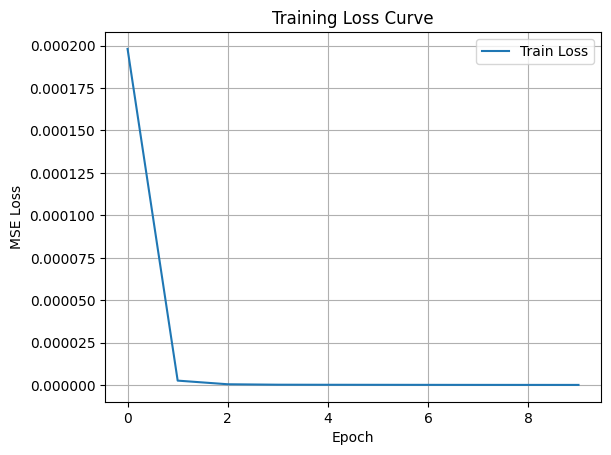

In [32]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.show()

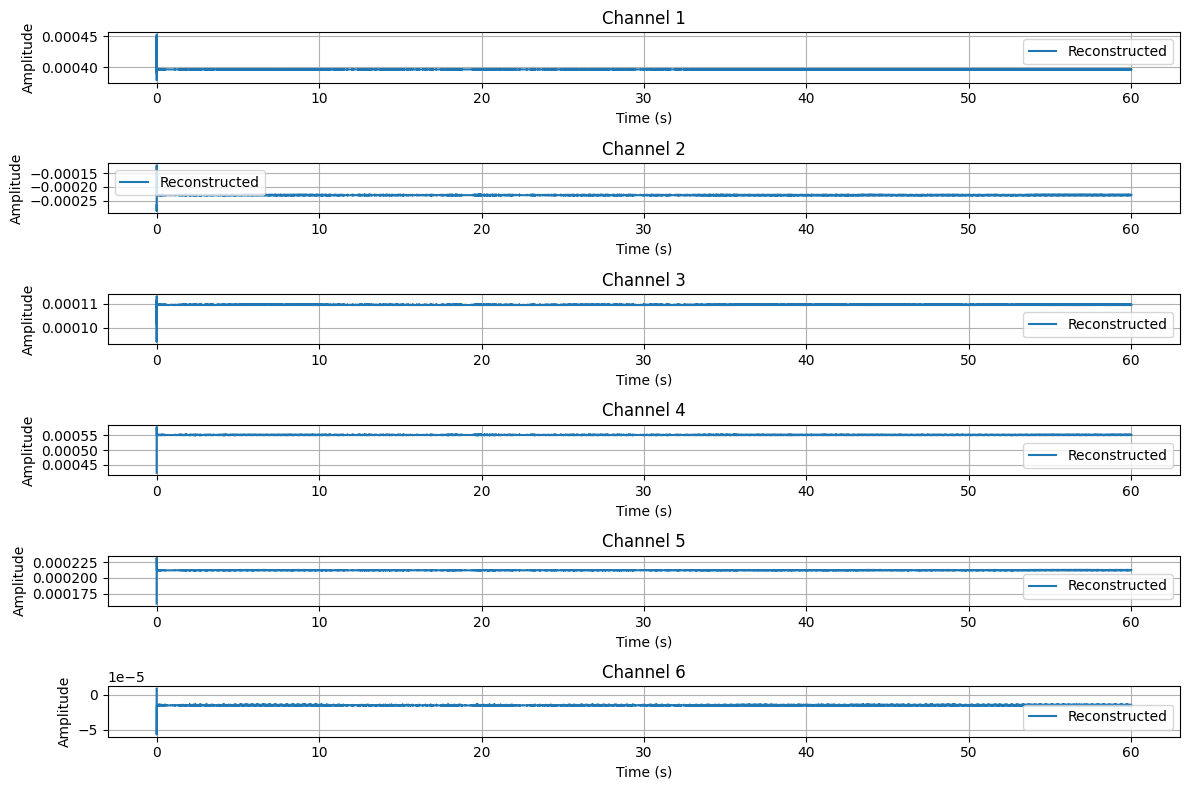

In [33]:
full_input = torch.tensor(selected_data, dtype=torch.float32).unsqueeze(0).to(device)
model.eval()
sample = dataset[0].unsqueeze(0).to(device)  
with torch.no_grad():
    reconstructed = model(full_input).cpu().squeeze(0).numpy()  

original = selected_data  


fs = 1651.61  
time = np.arange(original.shape[0]) / fs  


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i in range(original.shape[1]):  
    plt.subplot(original.shape[1], 1, i + 1)
    #plt.plot(time, original[:, i], label='Original')
    plt.plot(time, reconstructed[:, i], label='Reconstructed')
    plt.title(f'Channel {i+1}')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
print(reconstructed)
print(original)

[[ 4.48094943e-04 -2.67380034e-04  1.01740021e-04  4.22774814e-04
   1.59342628e-04  8.64647336e-06]
 [ 4.48819803e-04 -2.88184383e-04  1.12313835e-04  4.75237728e-04
   2.31669546e-04 -3.92331240e-05]
 [ 4.26949613e-04 -2.37578453e-04  9.39263409e-05  4.70419560e-04
   1.83139113e-04 -2.90107091e-05]
 ...
 [ 3.96505813e-04 -2.31178419e-04  1.09524844e-04  5.50770201e-04
   2.12174913e-04 -1.43095331e-05]
 [ 3.96373129e-04 -2.30910679e-04  1.09482906e-04  5.50919503e-04
   2.12251995e-04 -1.46660495e-05]
 [ 3.96280462e-04 -2.30612874e-04  1.09469671e-04  5.51071891e-04
   2.12257844e-04 -1.48697645e-05]]
[[ 1.2640399e-03  5.0079008e-05  2.3168529e-04  3.1044471e-04
   3.7325593e-05 -7.0127644e-05]
 [ 1.2183809e-03  7.8845835e-05  2.2002327e-04  3.0930163e-04
  -3.0662013e-05 -1.0023511e-04]
 [ 1.2390212e-03  8.3848761e-05  2.6053344e-04  3.5902674e-04
   5.7908994e-05 -5.1310479e-05]
 ...
 [ 3.6461843e-04 -2.3821462e-04  5.8596412e-05  4.8934092e-04
   3.6541256e-04  1.3748840e-04]
 [ 